## Figure 2: Cross-subject spatial and functional alignment

### Imports

In [1]:
import pandas as pd
from convergence.plotting import plot_faverage_parcelation, add_area_labels
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import numpy as np

# Matplotlib arial font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

### Functions

In [382]:
def save_brain_views(
    df,
    name,
    hemispheres=["lh", "rh"],
    views=["lateral", "medial", "rostral", "caudal", "dorsal", "ventral"],
    hcp=None,
    area_ids=None,
    size=(2*800, 2*600),
    adjust=False,
    formats=["png"],
    **kwargs,
):
    for hemi in hemispheres:
        brain = plot_faverage_parcelation(df, hemisphere=hemi, size=size, **kwargs)
        if hcp is not None:
            add_area_labels(brain, hcp=hcp, area_ids=area_ids, hemispheres=[hemi])

        for view in views:
            if view == 'lateral' and adjust:
                if hemi == 'lh':
                    brain.show_view("lateral", azimuth=20, elevation=-100)
                else:
                    brain.show_view("lateral", azimuth=-20, elevation=100)
            elif view == 'medial' and adjust:
                if hemi == 'lh':
                    brain.show_view("medial",  azimuth=-20, elevation=100)
                else:
                    brain.show_view("medial",  azimuth=20, elevation=-100)
            else:
                brain.show_view(view)
            for fmt in formats:
                brain.save_image(f"{name}_{hemi}_{view}.{fmt}", mode="rgba")
        brain.close()

def plot_cbar(figsize=None, cmap="viridis", vmin=0, vmax=0.2, horizontal=False, title="", percent=True, locator=0.05, rotation=-90, labelpad=20, fontsize=12, **kwargs):

    if figsize is None:
        figsize = (6, 0.4) if horizontal else (0.4, 6)
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a colormap normalization
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    # Create a scalar mappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for ScalarMappable

    # Add the colorbar
    orientation = 'horizontal' if horizontal else 'vertical'
    cbar_instance = fig.colorbar(sm, cax=ax, orientation=orientation, **kwargs)
    cbar_instance.set_label(title, rotation=rotation, labelpad=labelpad, fontsize=fontsize)
    
    if percent:
        ticker = mticker.PercentFormatter(xmax=1, decimals=0)
        cbar_instance.formatter = ticker
    if locator:
        cbar_instance.locator = mticker.MultipleLocator(base=locator)

    
    return fig, ax

def plot_all_rois(df, ax, order, hue_order, palette, title=None, legend=True, fontsize=7, legend_fontsize=9, vmax=0.26, legend_kwargs={}):


    sns.boxplot(
        data=df,
        x="name",
        hue="area",
        y="score",
        ax=ax,
        order=order,
        hue_order=hue_order,
        palette=palette,
        legend=legend,
    )

    if legend:
        ax.legend(loc="upper right", ncol=2, fontsize=legend_fontsize, **legend_kwargs)

    ax.set_ylabel("Alignment (CKA)")
    ax.set_xlabel("")
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)
    # ax.grid(axis='y', linestyle='--', alpha=0.5)
    for v in range(1, 7):
        color = "maroon" if v == 0 else "gray"
        ax.axhline(v * 0.05, color=color, linestyle="--", lw=0.5, zorder=-1)

    s = 0
    counts = df.drop_duplicates("name").area.value_counts().to_dict()
    for area in hue_order:
        s = s + counts[area]
        ax.axvline(s - 0.5, color="gray", ls="--", alpha=0.5, lw=0.3, zorder=-10)

    eps = 1
    ax.set_xlim(-eps, len(order) + eps)
    ax.set_ylim(-0.01, vmax)
    sns.despine(ax=ax)
    if title is not None:
        # Move into the plot
        ax.set_title(title, fontsize=14)

def load_model_spatial(filename, filename_hcp, modality='vision', join_subject: bool = True):
    df = pd.read_parquet(filename)
    df = df.query(f"modality=='{modality}' and metric=='unbiased_cka' and score<1 "
                  "and score>-0.05 and not excluded").copy()
    df = df.groupby(["model_name", "roi", "subject", "session"], observed=True).aggregate({"score": "max"}).reset_index()
    df = df.groupby(["model_name", "roi", "subject"], observed=True).aggregate({"score": "mean"}).reset_index()
    df = df.groupby(["roi", "subject"], observed=True).aggregate({"score": "mean"}).reset_index()
    if join_subject:
        df = df.groupby(["roi"], observed=True).aggregate({"score": "mean"}).reset_index()
    
    hcp = pd.read_csv(filename_hcp)
    hcp = hcp[["roi", "name", "area_id", "area", "mne_name", "roi_order", "area_color"]]
    df = df.merge(hcp, on="roi")

    return df

def load_cross_participant(filename, filename_hcp, join_subject: bool = True):
    df = pd.read_parquet(filename)
    hcp = pd.read_csv(filename_hcp)
    df_g = df.query("score < 1 and score > -0.05 and roi_x == roi_y and subject_i != subject_j").copy()
    df_g = df_g.groupby(["roi_x", "subject_i"]).aggregate({"score": "mean"}).reset_index()
    if join_subject:
        df_g = df_g.groupby("roi_x").aggregate({"score": "mean"}).reset_index()
    df_g = df_g.rename(columns={"roi_x": "roi"})
    df_g = df_g.merge(hcp[["mne_name", "roi"]], on="roi")
    return df_g

def plot_comparison(df, x, y, xlabel="", ylabel="", threshold = 0.038, add_identity=False, ylim=None, xlim=None, custom={}, scatter_kws={}, fontsize=6, legend=False):
    areas = df[['area_id', "area", "area_color"]].sort_values("area_id").drop_duplicates("area_id")
    
    hue_order = list(areas.area.tolist())
    palette = list(areas.area_color.tolist())

    g = sns.jointplot(data=df, x=x, y=y, kind='scatter', marginal_kws=dict(bins=50, color='gray'), ylim=ylim, xlim=xlim)
    ax = g.ax_joint
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    ax.clear()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    sns.scatterplot(data=df, x=x, y=y, hue='area', palette=palette, hue_order=hue_order, ax=ax, legend=legend,  zorder=10, **scatter_kws)
    if add_identity:
        ax.plot([0, 1], [0, 1], ls='--', lw=0.5, color='maroon', zorder=-10)
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Add roi names as text labels
    for _, row in df.query(f"{y}>{threshold} or {x}>{threshold}").iterrows():
        shift_y = 0.004
        shift_x = 0
        name = row["name"]
        if name in custom:
            shift_x, shift_y = custom[name]
        ax.text(row[x] + shift_x, row[y]+shift_y, name, ha='center', va='center', fontsize=fontsize, font='Arial', color='black', zorder=20)
    return g


def add_pvalue_bracket(ax, x1, x2, y, height, color=(0.24, 0.24, 0.24), linewidth=1, text=None, y_text=None, **kwargs):
    """
    Draws a bracket (like those used to denote p-values) on a given axis.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis on which to plot the bracket.
    x1, x2 : float
        The x-coordinates between which the bracket is drawn.
    y : float
        The y-coordinate at which the bracket starts.
    height : float
        The vertical distance (height) of the bracket.
    color : str, optional
        The color of the lines.
    linewidth : float, optional
        The width of the lines.
    """
    # Draw the bracket:
    #   Vertical line up from (x1, y) to (x1, y+height)
    #   Horizontal line from (x1, y+height) to (x2, y+height)
    #   Vertical line down from (x2, y+height) to (x2, y)
    ax.plot([x1, x1, x2, x2],
            [y, y + height, y + height, y],
            color=color, linewidth=linewidth)
    if text:
        if not y_text:
            y_text = y + height
        ax.text((x1 + x2) * .5, y_text, text, ha='center', **kwargs)
    



### Data

In [3]:
data_folder = Path("./data")
filename_separated = data_folder / "cross_subject_pairwise_similarities_0_separated_unbiased_cka.parquet"
filename_joined = data_folder / "cross_subject_pairwise_similarities_0_joined_unbiased_cka.parquet"
filename_hcp = data_folder / "hcp3.csv"
filename_model_joined = data_folder / "subject_model_similarities_cka_joined.parquet"
filename_model_separated = data_folder / "subject_model_similarities_cka.parquet"

filename_separated_shift = data_folder / "cross_subject_pairwise_similarities_1_separatedparquet"
filename_partitions = data_folder / "cross_subject_partitions.parquet"
output_folder = Path("figure_spatial_alignment")
output_folder.mkdir(exist_ok=True)

### Subfigs: Brain spatial alignment across subjects

In [4]:
df = pd.read_parquet(filename_separated)
hcp = pd.read_csv(filename_hcp)
df_g = df.query("score < 1 and score > -0.05 and roi_x == roi_y and subject_i != subject_j").copy()
#df_g.score = df_g.score.clip(0, 1) # Not needed, no values are outside the range
df_g = df_g.groupby(["roi_x", "subject_i"]).aggregate({"score": "mean"}).reset_index()
df_g = df_g.groupby("roi_x").aggregate({"score": "mean"}).reset_index()
df_g = df_g.rename(columns={"roi_x": "roi"})
df_g = df_g.merge(hcp[["mne_name", "roi"]], on="roi")
vlims = (0, 0.20)

folder = output_folder / Path("cross_subject_brain") 
folder.mkdir(exist_ok=True)

# Save without labels
# Areas: V1, V2-V4, Ventral, PH, Dorsal, MT+, TPOJ
# areas = df_g[["roi", "score"]].merge(hcp, on="roi").query("score>0.05").area_id.unique()
areas = [0,1,2,3,4,5,7]
for area in (areas, None):
    name = "mean_cka_brain_cross" if area is None else "mean_cka_brain_cross_labels"
    hcp = None if area is None else pd.read_csv(filename_hcp)
    save_brain_views(
        df=df_g,
        name=str(folder / name),
        hemispheres=["lh", "rh"],
        views=["lateral", "medial", "caudal", "ventral"],
        normalize=vlims,
        area_ids=area,
        hcp=hcp,
        adjust=False,
        formats=["png", "tiff"],
        default_color="gray", default_value=None,
    )


In [5]:
name = "mean_cka_brain_cross_labels_cluster"
hcp = pd.read_csv(filename_hcp)
hcp["cluster"] = 0

mt_cluster = ["MST", "MT", "V4t", "FST", "TPOJ2", "TPOJ3"]
ppa_cluster = ["PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"]
hcp["cluster"] = 0
hcp.loc[hcp.name.isin(mt_cluster), "cluster"] = 2
hcp.loc[hcp.name.isin(mt_cluster), "area_color"] = "#2ca02c"
hcp.loc[hcp.name.isin(ppa_cluster), "cluster"] = 1
hcp.loc[hcp.name.isin(ppa_cluster), "area_color"] = "white"

areas = [1, 2]
hcp = hcp.drop(columns=["area_id"])
hcp = hcp.rename(columns={"cluster": "area_id"})

save_brain_views(
        df=df_g,
        name=str(folder / name),
        hemispheres=["lh", "rh"],
        views=["lateral", "medial", "caudal", "ventral"],
        normalize=vlims,
        area_ids=areas,
        hcp=hcp,
        adjust=True,
        formats=["png", "tiff"],
        default_color="gray", default_value=0,
        size = (4*800, 4*600),
    )

In [6]:
hcp.query("name=='MST'")

,Unnamed: 0,roi,name,description,full_name,other_names,studies,atlas,hemisphere,mne_name,area,roi_order,area_color,area_id
1,1,2,MST,Medial Superior Temporal Area,Left Medial Superior Temporal Area (MST),"MSTv, hOC5, hOC5v","Abdollahi et al 2014, Kolster et al 2010, Mali...",lh.HCP_MMP1,lh,L_MST_ROI-lh,MT+ Visual Areas,24,#2ca02c,2
181,181,182,MST,Medial Superior Temporal Area,Right Medial Superior Temporal Area (MST),"MSTv, hOC5, hOC5v","Abdollahi et al 2014, Kolster et al 2010, Mali...",rh.HCP_MMP1,rh,R_MST_ROI-rh,MT+ Visual Areas,24,#2ca02c,2


Colorbars

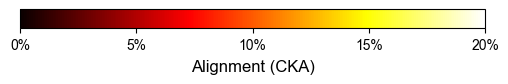

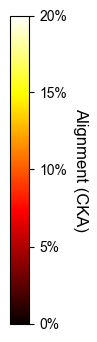

: 

In [ ]:
fig, ax = plot_cbar(cmap="hot", title="Alignment (CKA)", vmin=0, vmax=0.20, locator=0.05, horizontal=True, rotation=0, labelpad=5, figsize = (6, 0.25))
folder = output_folder / Path("colorbars")
fig.savefig(folder / "colorbar_20_hot.svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(folder / "colorbar_20_hot.pdf", bbox_inches="tight", dpi=300, transparent=True)
#plt.close()

fig, ax = plot_cbar(cmap="hot", title="Alignment (CKA)", vmin=0, vmax=0.20, locator=0.05, horizontal=False, rotation=-90, labelpad=15, figsize = (0.25, 4))
fig.savefig(folder / "colorbar_20_hot_vertical.svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(folder / "colorbar_20_hot_vertical.pdf", bbox_inches="tight", dpi=300, transparent=True)
#plt.close()

In [ ]:
df = pd.read_parquet("data/cross_subject_pairwise_similarities_0_separated.parquet")
hcp = pd.read_csv(filename_hcp)
df
df_g = df.query("score < 1 and score > -0.05 and roi_x == roi_y and subject_i != subject_j").copy()

df_g.score = df_g.score.clip(0, 1) # Not needed, no values are outside the range
df_g = df_g.groupby(["roi_x", "subject_i"]).aggregate({"score": "mean"}).reset_index()
df_g = df_g.groupby("roi_x").aggregate({"score": "mean"}).reset_index()
df_g = df_g.rename(columns={"roi_x": "roi"})
df_g = df_g.merge(hcp[["mne_name", "roi"]], on="roi")
vlims = (0, 0.18)


folder = output_folder / Path("cross_subject_brain_shift") 
folder.mkdir(exist_ok=True)

#  Save without labels
# Areas: V1, V2-V4, Ventral, PH, Dorsal, MT+, TPOJ
# areas = df_g[["roi", "score"]].merge(hcp, on="roi").query("score>0.05").area_id.unique()
areas = [0,1,2,3,4,5,7]
for area in (areas, None):
    name = "mean_cka_brain_cross_shift" if area is None else "mean_cka_brain_cross_labels_shift"
    hcp = None if area is None else pd.read_csv(filename_hcp)
    save_brain_views(
        df=df_g,
        name=str(folder / name),
        hemispheres=["lh", "rh"],
        views=["lateral", "ventral"],
        normalize=vlims,
        area_ids=area,
        hcp=hcp,
        adjust=False,
        formats=["png", "tiff"],
        default_color="gray", default_value=None,
    )


### Subfigs: Boxplot with cross-participant variability

Top areas with more alignment

In [4]:
df = pd.read_parquet(filename_joined)
hcp = pd.read_csv(filename_hcp)
hcp.area = hcp.area.replace({"Early Visual (V2-4)": "Early Visual (V2-V4)"})
hcp.name = hcp.name.replace({"H": "Hipp"})
hcp = hcp[["roi", "name", "roi_order", "area_color", "area_id", "area"]]
df = df.query(
    "roi_x == roi_y and metric=='unbiased_cka' and subject_i != subject_j and score < 1 and score > -0.05"
).copy()
df = df.rename(columns={"roi_x": "roi"})
df.score = df.score.clip(0, 1)
df_g = df.groupby(["subject_i", "roi"]).aggregate({"score": "mean"}).reset_index()
df_g = df_g.rename(columns={"subject_i": "subject"})
df_g = df_g.merge(hcp, on="roi")
df_g = df_g.groupby(["roi", "area_id"]).aggregate({"score": "mean"}).reset_index()
df_g = df_g.groupby("area_id").aggregate({"score": "max"}).reset_index()
area_id = df_g.sort_values("score", ascending=False).head(10).sort_values("area_id").area_id.tolist()
area_id

[0, 1, 2, 3, 4, 5, 6, 7, 16, 17]

In [ ]:
# hcp3 = pd.read_csv(filename_hcp)
# hcp3.area_id = hcp3.area_id.replace({
#   5: 3,
#   3: 5,  
# })
# hcp3.area_id = hcp3.area_id.replace({
#   4:6,
#   6:4
# })
# hcp3.roi_order = hcp3.roi_order.replace({
#    11:10,
#    12:11,
#    16:12,
#    10:13,
#    13:14,
#    14:15,
#    15:16,

#    84:79,
#    85:80,
#    86:81,
#     79:82,
#     80:83,
#     81:84,
#     82:85,
#     83:86,

#     18:17,
#     19:18,
#     20:19,
#     23:20,
#     24:21,
#     25:22,
#     17:23,
#     21:24,
#     22:25,

#     99:95,
#     98:96,
#     97:97,
#     95:98,
#     96:99,
# })

# hcp3.area_color = hcp3.area_color.replace({
#     '#98df8a': "#ffbb78",
#     "#ffbb78": "#ff9896",
#     "#ff9896": '#98df8a',
# })

# # 'data/hcp3.csv'
# hcp3.to_csv('data/hcp3.csv')


In [469]:
df_pvalues = pd.read_parquet("stats/nsd_cka_cross_subject_permutations_pvalues_roi.parquet")
df_pvalues = df_pvalues.merge(hcp[['roi', "area_id", "roi_order", "area"]], on='roi')
selected_areas = [0, 1, 2, 3, 4, 5, 6, 7, 16, 17]
df_pvalues = df_pvalues.query("area_id in @selected_areas").copy()
df_pvalues = df_pvalues.sort_values(["area_id", "roi_order"])
very_significant_rois = df_pvalues.query("pvalue_corrected < 0.001").roi.tolist()
#df_pvalues.null_mean = df_pvalues.null_mean.clip(0, 1)
#df_pvalues = df_pvalues.query("roi in @very_significant_rois").reset_index().copy()

In [470]:
df_permutations = pd.read_parquet("data/nsd_cka_cross_subject_permutations.parquet")#.query("repetition <= 5000")
df_permutations = df_permutations.query("permuted == True and cka < 1 and cka > -0.01")# and roi in @very_significant_rois").copy()
df_permutations.cka = df_permutations.cka.clip(0, 1)
df_permutations2 = df_permutations.copy()
df_permutations2["subject_i"], df_permutations2["subject_j"] = df_permutations2["subject_j"], df_permutations2["subject_i"]
df_permutations = pd.concat([df_permutations, df_permutations2], axis=0)
df_permutations = df_permutations.groupby(["repetition", "roi"]).aggregate({"cka": "mean"}).reset_index()
df_permutations = df_permutations.merge(hcp[['roi', "area_id", "roi_order", "area", "name"]], on='roi')
df_permutations = df_permutations.merge(df_pvalues[["roi"]].reset_index().rename(columns={"index": "order"}), on='roi')
df_permutations = df_permutations.sort_values(["area_id", "roi_order", "repetition"])
df_permutations.cka = df_permutations.cka.clip(0, 1)
df_permutations.roi.nunique()

70

In [471]:
df_permutations

,repetition,roi,cka,area_id,roi_order,area,name,order
0,1,1,0.000783,0,0,Primary Visual,V1,0
70,2,1,0.000978,0,0,Primary Visual,V1,0
140,3,1,0.000903,0,0,Primary Visual,V1,0
210,4,1,0.001028,0,0,Primary Visual,V1,0
280,5,1,0.000655,0,0,Primary Visual,V1,0
...,...,...,...,...,...,...,...,...
839674,11996,33,0.000187,17,132,Posterior Cingulate,v23ab,32
839744,11997,33,0.000395,17,132,Posterior Cingulate,v23ab,32
839814,11998,33,0.000362,17,132,Posterior Cingulate,v23ab,32
839884,11999,33,0.000370,17,132,Posterior Cingulate,v23ab,32


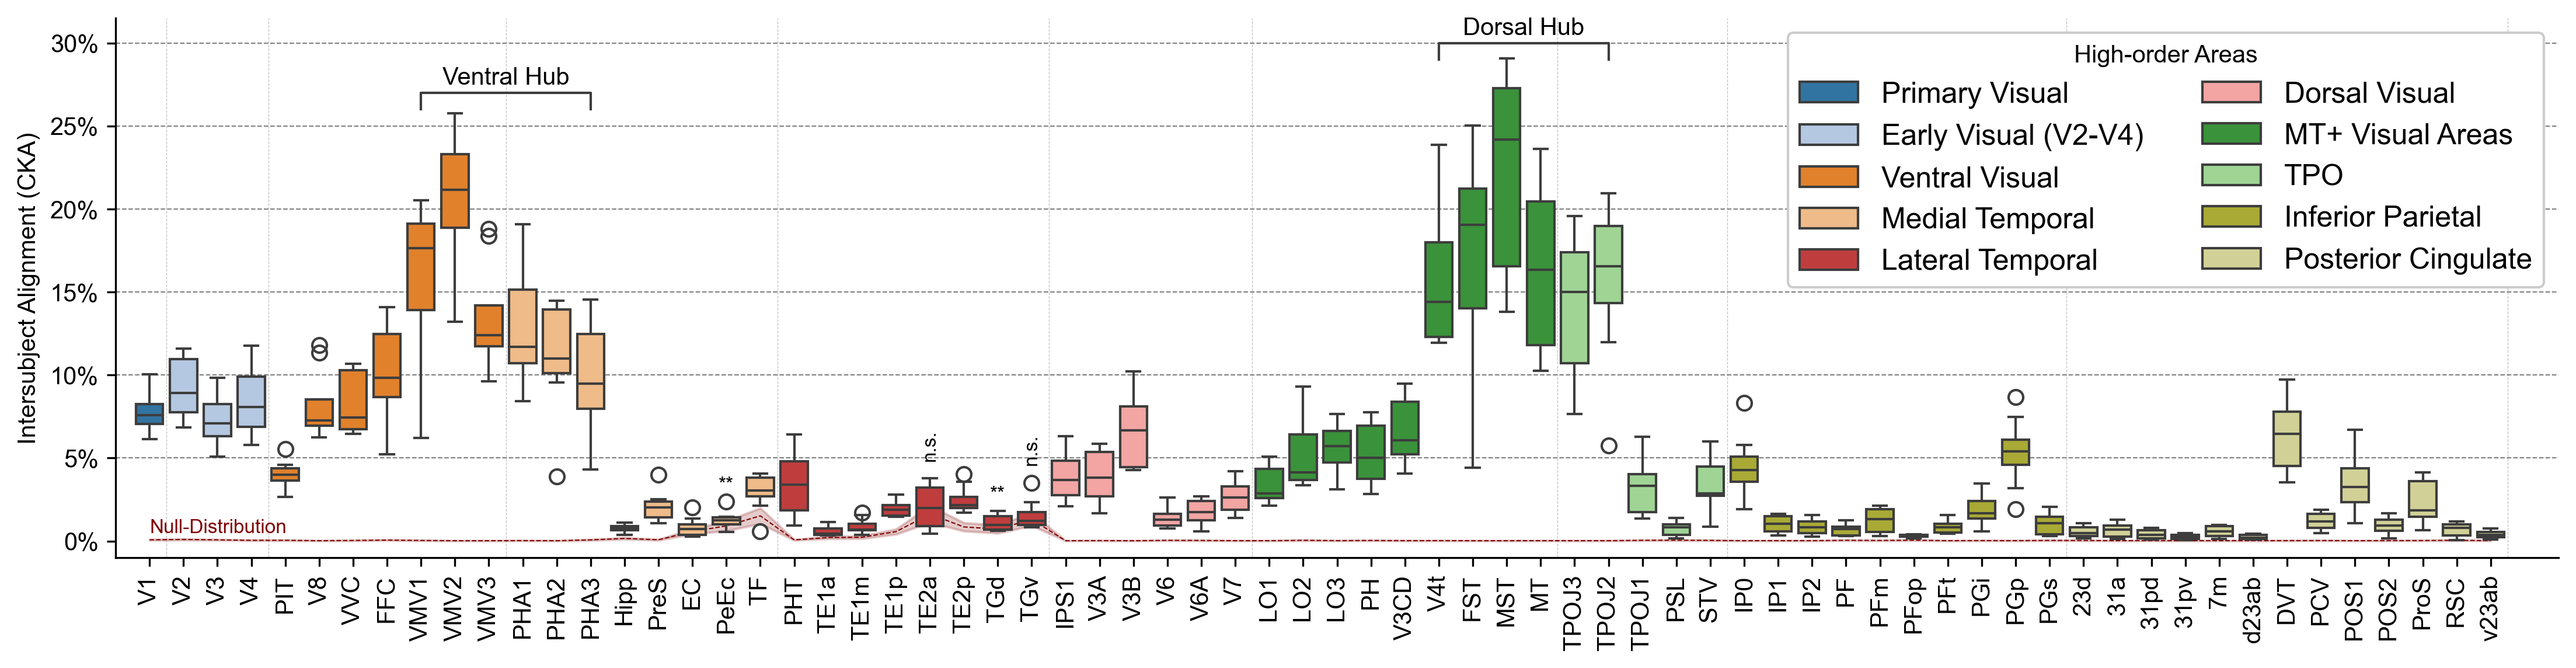

In [494]:
df = pd.read_parquet(filename_joined)
hcp = pd.read_csv(filename_hcp)
hcp.area = hcp.area.replace({"Early Visual (V2-4)": "Early Visual (V2-V4)"})
hcp.name = hcp.name.replace({"H": "Hipp"})
hcp = hcp[["roi", "name", "roi_order", "area_color", "area_id", "area"]]
df = df.query(
    "roi_x == roi_y and metric=='unbiased_cka' and subject_i != subject_j and score < 1 and score > -0.05"
).copy()
df = df.rename(columns={"roi_x": "roi"})
df.score = df.score.clip(0, 1)
df_g = df.groupby(["subject_i", "roi"]).aggregate({"score": "mean"}).reset_index()
df_g = df_g.rename(columns={"subject_i": "subject"})
df_g = df_g.merge(hcp, on="roi")

selected_areas = [0, 1, 2, 3, 4, 5, 6, 7, 16, 17]
df_g_filtered = df_g.query("area_id in @selected_areas")# and roi in @very_significant_rois").copy()
df_g_filtered = df_g_filtered.sort_values(["area_id", "roi_order"]).reset_index(drop=True)

order = df_g_filtered.sort_values(["area_id", "roi_order"]).name.unique()
hue_order = df_g_filtered.sort_values("area_id").area.unique()
palette = list(df_g_filtered.sort_values("area_id").area_color.unique())

fig, ax = plt.subplots(1, 1, figsize=(18, 4), dpi=300)
plot_all_rois(
    df_g_filtered,
    ax,
    order,
    hue_order,
    palette,
    title="",
    legend=True,
    fontsize=10,
    legend_fontsize=12,
    legend_kwargs={"bbox_to_anchor": (1, 1), "title": "High-order Areas"},
    vmax=0.3
)
ax.set_ylabel("Intersubject Alignment (CKA)")

#ax.axhline(0, color='maroon', linestyle="--", lw=0.5, zorder=-1)
#ax.plot(np.arange(0, len(df_pvalues)), df_pvalues.null_mean, color='maroon', ls='--', zorder=-1, lw=0.5)
#sns.lineplot(data=df_permutations, x="order", y="cka", ax=ax, color='maroon', lw=0.5, zorder=-1, errorbar="sd", ls='--', sort=False)

df_permutations = df_permutations[df_permutations.roi.isin(df_g_filtered.roi.unique())].sort_values(["area_id", "roi_order"]).reset_index(drop=True)
assert df_permutations.roi.nunique() == df_g_filtered.roi.nunique()


order_dict = {name: i for i, name in enumerate(order)}
df_permutations["order"] = df_permutations.name.map(order_dict)
df_permutations = df_permutations.sort_values("order")


sns.lineplot(data=df_permutations, x="order", y="cka", color='maroon', lw=0.5, zorder=-1, errorbar="sd", ls='--', legend=False, sort=True, ax=ax)

# Add a text in marron on x=1, y=0 with the text "Null-Distribution Mean"
ax.text(0, 0.008, "Null-Distribution", ha='left', va='center', fontsize=8, font='Arial', color='maroon')
ax.set_xlabel("")
ax.get_legend().get_frame().set_alpha(1) 


folder_boxplots = output_folder / Path("cross_subject_boxplots")
folder_boxplots.mkdir(exist_ok=True)

ax.set_ylim(None, 0.315)
add_pvalue_bracket(ax=ax, x1=8, x2=13, y=0.26, height=0.01, text="Ventral Hub", y_text=0.275)
add_pvalue_bracket(ax=ax, x1=38, x2=43, y=0.29, height=0.01, text="Dorsal Hub", y_text=0.305)

df_pvalues["order"] = df_pvalues.name.map(order_dict)
df_pvalues_selected = df_pvalues[df_pvalues.order.notna()].sort_values("order").copy()
df_pvalues_selected["order"] = df_pvalues_selected["order"].astype(int)
#df_pvalues_selected

df_pvalues_selected_different_significant = df_pvalues_selected.query("significance != '***'")
for i, row in df_pvalues_selected_different_significant.iterrows():
    max_score = (df_g_filtered.query(f"name=='{row['name']}'")).score.max()
    significance = row["significance"].replace("ns", "n.s.")
    rotation = 0 if "*" in significance else 90
    adjust = 0.01 if "*" in significance else 0.02
    ax.text(row["order"], max_score + adjust, row["significance"].replace("ns", "n.s."), ha='center', va='center', fontsize=8, font='Arial', color='black', zorder=20, rotation=rotation)

fig.savefig(folder_boxplots / "cross_subject_boxplots.svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(folder_boxplots / "cross_subject_boxplots.pdf", bbox_inches="tight", dpi=300, transparent=True)


Generate a separated legend if needed

In [64]:
fig, ax2 = plt.subplots()
ax2.axis('off')
leg2 = ax2.legend(*ax.get_legend_handles_labels(), ncol=2, loc="center")
fig.tight_layout()
fig.savefig(folder_boxplots / "reduced_legend.pdf", bbox_inches="tight", transparent=True)
plt.close()

### Subfigs: Boxplot with all ROIs for extra figures

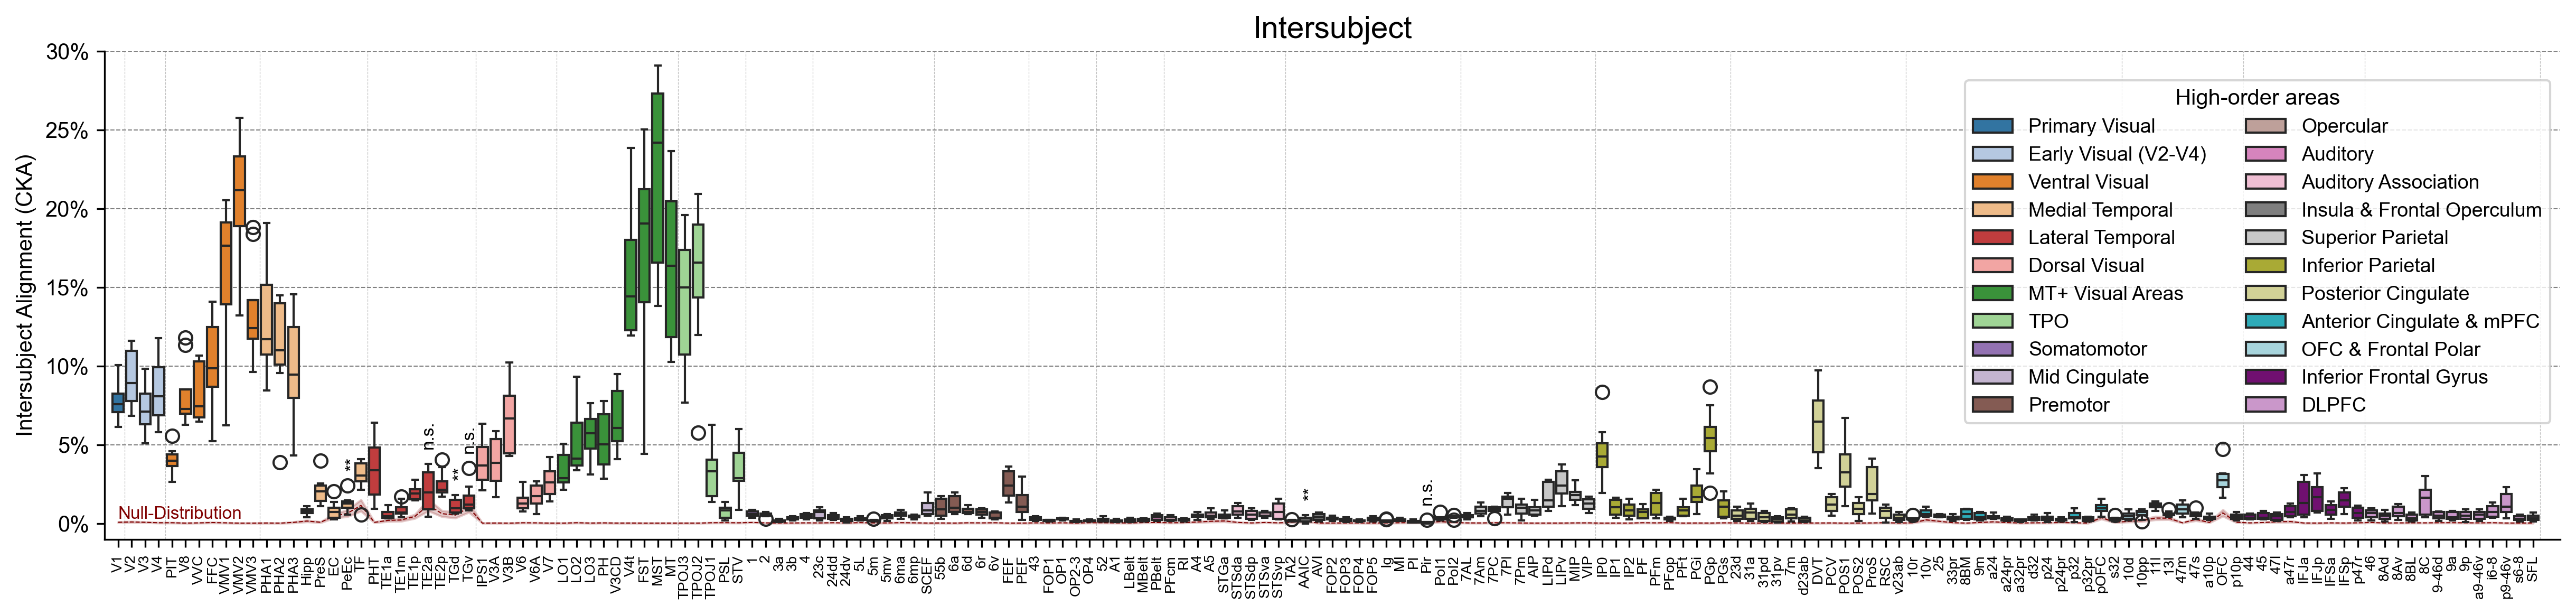

In [462]:
df_g = df_g.sort_values(["area_id", "roi_order"]).copy()
order = df_g.sort_values(["area_id", "roi_order"]).name.unique()
hue_order = df_g.sort_values("area_id").area.unique()
palette = list(df_g.sort_values("area_id").area_color.unique())

df_pvalues = pd.read_parquet("stats/nsd_cka_cross_subject_permutations_pvalues_roi.parquet")
df_pvalues = df_pvalues.merge(hcp[['roi', "area_id", "roi_order", "area"]], on='roi')
df_pvalues = df_pvalues.sort_values(["area_id", "roi_order"])

df_permutations = pd.read_parquet("data/nsd_cka_cross_subject_permutations.parquet")#.query("repetition <= 5000")
df_permutations = df_permutations.query("permuted == True and cka<0.2 and cka>-0.1 ").copy()
df_permutations.cka = df_permutations.cka.clip(0, 1)
df_permutations2 = df_permutations.copy()
df_permutations2["subject_i"], df_permutations2["subject_j"] = df_permutations2["subject_j"], df_permutations2["subject_i"]
df_permutations = pd.concat([df_permutations, df_permutations2], axis=0)
df_permutations = df_permutations.groupby(["repetition", "roi"]).aggregate({"cka": "mean"}).reset_index()
df_permutations = df_permutations.merge(hcp[['roi', "area_id", "roi_order", "area", "name"]], on='roi')
#df_permutations.cka = df_permutations.cka.clip(0, 1)

df_gg = df_g.groupby(["roi", "name", "area_id","roi_order"]).score.max().reset_index().sort_values(["area_id", "roi_order"])
df_gg = df_gg.set_index("name")
df_pvalues.name =df_pvalues.name.replace("H", "Hipp")
df_pvalues = df_pvalues.set_index("name")


# Add the order of the rois based on the variable order (a list with names)
df_permutations["order"] = df_permutations.roi.replace({roi: i for i, roi in enumerate(order)})

for legend in [True]:
    l = "_no_legend" if not legend else ""
    fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=300)
    plot_all_rois(df_g, ax, order, hue_order, palette, title="Intersubject", legend=legend, fontsize=6.5, legend_kwargs={'bbox_to_anchor': (1, 0.96)}, vmax=0.30)
    
    #plt.close()
    # Add title "High-order areas" to the legend
    if legend:
        ax.legend_.set_title("High-order areas")
    ax.set_ylabel("Intersubject Alignment (CKA)")
    ax.set_xlabel("")
    # Add the null distribution mean name
    ax.text(0, 0.006, "Null-Distribution", ha='left', va='center', fontsize=8, font='Arial', color='maroon')
    #ax.plot(np.arange(0, len(df_pvalues)), df_pvalues.loc[order].null_mean.to_list(), color='maroon', lw=0.5, zorder=-1, ls='--')
    #sns.lineplot(data=df_permutations, x="order", y="cka", ax=ax, color='maroon', lw=0.5, zorder=-1, errorbar="sd", ls='--', legend=False, marker=True)
    sns.lineplot(data=df_permutations.sort_values(["area_id", "roi_order"]), x="name", y="cka", color='maroon', lw=0.5, zorder=-1, errorbar="sd", ls='--', legend=False, sort=False, ax=ax)
    ax.set_xlabel("")
    for i, name in enumerate(order):
        df_gg_name = df_gg.loc[name]
        df_pvalues_name = df_pvalues.loc[name]
        score = df_gg_name.score
        pvalue = df_pvalues_name.pvalue_corrected
        significance = df_pvalues_name.significance.replace("ns", "n.s.")
        if significance != "***":
            adjust = 0 if significance == "n.s." else 0.4
            ax.text(i+adjust, score + 0.012, significance, ha='center', va='baseline', fontsize=8, font='Arial', color='black', rotation=90)
    
    #fig.savefig(folder_boxplots / f"cross_subject_all_boxplots{l}.pdf", bbox_inches="tight", dpi=300, transparent=True)
    #fig.savefig(folder_boxplots / f"cross_subject_all_boxplots{l}.svg", bbox_inches="tight", dpi=300, transparent=True)
        


Generate a separated legend

In [ ]:
fig, ax2 = plt.subplots()
ax2.axis('off')
leg2 = ax2.legend(*ax.get_legend_handles_labels(), ncol=2, loc="center")
fig.tight_layout()
fig.savefig(folder_boxplots / "full_legend.pdf", bbox_inches="tight", transparent=True)
fig.savefig(folder_boxplots / "full_legend.svg", bbox_inches="tight", transparent=True)
plt.close()

### Subfigs: Box plot with all ROIs separated by hemisphere

In [ ]:
df = pd.read_parquet(filename_separated)
df = df.query(
     "roi_x == roi_y and metric=='unbiased_cka' and subject_i != subject_j and score < 1 and score > -0.05"
).copy()
df = df.rename(columns={"roi_x": "roi"})
df.score = df.score.clip(0, 1)
df_g = df.groupby(["subject_i", "roi"]).aggregate({"score": "mean"}).reset_index()
df_g = df_g.rename(columns={"subject_i": "subject"})
df_g = df_g.merge(hcp, on="roi")
df_g_both = df_g.copy()

for hemi in ["lh", "rh"]:
    if hemi == 'lh':
        df_g = df_g_both.query("roi <= 180")
    else:
        df_g = df_g_both.query("roi > 180")

    fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=300)
    plot_all_rois(df_g, ax, order, hue_order, palette, title=f"Cross-subject ({hemi.upper()})", legend=False, fontsize=6.5, legend_kwargs={'bbox_to_anchor': (1, 0.96)}, vmax=0.3)
    fig.savefig(folder_boxplots / f"cross_subject_all_boxplots_{hemi}.pdf", bbox_inches="tight", dpi=300, transparent=True)
    plt.close()

### Subfigs: Comparison alignment per hemisphere

     area_id                        area area_color
0          0              Primary Visual    #1f77b4
3          1         Early Visual (V2-4)    #aec7e8
162        2              Ventral Visual    #ff7f0e
134        3             Medial Temporal    #ffbb78
136        4            Lateral Temporal    #d62728
151        5               Dorsal Visual    #ff9896
158        6            MT+ Visual Areas    #2ca02c
140        7                         TPO    #98df8a
8          8                 Somatomotor  lightgray
38         9               Mid Cingulate  lightgray
9         10                    Premotor  lightgray
98        11                   Opercular  lightgray
173       12                    Auditory  lightgray
103       13        Auditory Association  lightgray
105       14  Insula & Frontal Operculum  lightgray
41        15           Superior Parietal  lightgray
115       16           Inferior Parietal    #bcbd22
29        17         Posterior Cingulate    #dbdb8d
165       18

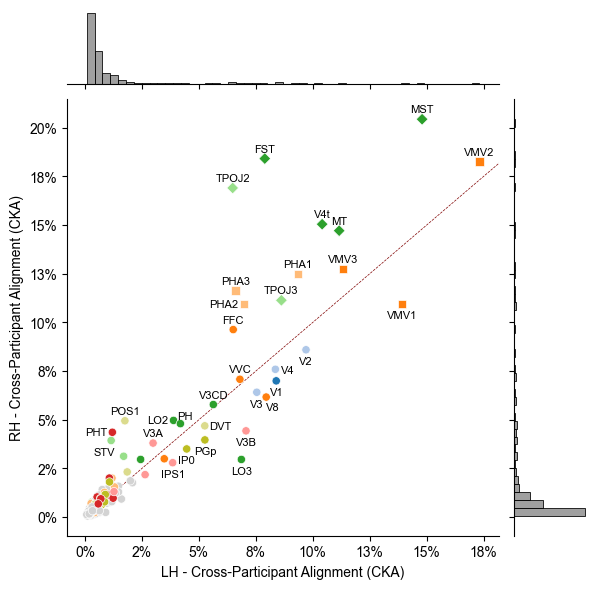

In [85]:

df = pd.read_parquet(filename_separated)
df = df.query(
     "roi_x == roi_y and metric=='unbiased_cka' and subject_i != subject_j and score < 1 and score > -0.05"
).copy()

hcp = pd.read_csv(filename_hcp)
hcp.loc[~hcp.area_id.isin(selected_areas), "area_color"] = "lightgray"

df = df.rename(columns={"roi_x": "roi"})
df.score = df.score.clip(0, 1)
df_g = df.groupby(["roi"]).aggregate({"score": "mean"}).reset_index()
df_g = df_g.rename(columns={"subject_i": "subject"})
df_g = df_g.merge(hcp, on="roi")
df_lh = df_g.query("roi <= 180").copy()
df_rh = df_g.query("roi > 180").copy()
df_rh.roi -= 180
df_rh = df_rh[['roi', "score"]].rename(columns={'score': 'score_rh'})
df_lh = df_lh.rename(columns={'score': 'score_lh'})
df_g = df_lh.merge(df_rh, on='roi')
df_g["cluster"] = 0
df_g.loc[df_g.name.isin(mt_cluster), "cluster"] = 2
df_g.loc[df_g.name.isin(ppa_cluster), "cluster"] = 1


areas = df_g[['area_id', "area", "area_color"]].sort_values("area_id").drop_duplicates("area_id")
print(areas)
hue_order = list(areas.area)
palette = list(areas.area_color)


g = sns.jointplot(data=df_g, x='score_lh', y='score_rh', kind='scatter', marginal_kws=dict(bins=50, color='gray'))

ax = g.ax_joint
ylims = ax.get_ylim()
xlims = ax.get_xlim()
ax.clear()
ax.set_xlim(xlims)
ax.set_ylim(ylims)

sns.scatterplot(data=df_g, x='score_lh', y='score_rh', hue='area', palette=palette, hue_order=hue_order, ax=ax, legend=False, style="cluster", markers={0: 'o', 1: 's', 2: 'D'})

# Plot x=y dashline
ax.plot([0, 1], [0, 1], ls='--', lw=0.5, color='maroon', zorder=-10)

# Add roi names as text
threshold = 0.038
for i, row in df_g.query("score_rh>@threshold or score_lh>@threshold").iterrows():
    shift_y = 0.005 if row.score_rh > row.score_lh else -0.006
    shift_x = 0
    name = row["name"]
    custom = {
        'PHA2': (-0.009, 0.0),
        "V4": (0.0055, -0.0005),
        "V8": (0.003, -0.005),
        "LO2": (-0.007, 0),
        "PH": (0.002, 0.004),
        "PHT": (-0.007, 0),
        "STV": (-0.003, -0.006),
        "DVT": (0.007, 0)
    }
    if name in custom:
        shift_x, shift_y = custom[name]
    ax.text(row.score_lh + shift_x, row.score_rh+shift_y, name, ha='center', va='center', fontsize=8, font='Arial', color='black')

# Set percent tick formatters
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax.set_xlabel("LH - Cross-Participant Alignment (CKA)")
ax.set_ylabel("RH - Cross-Participant Alignment (CKA)")

folder_hemispheres = output_folder / Path("cross_subject_hemispheres")
folder_hemispheres.mkdir(exist_ok=True)

g.savefig(folder_hemispheres / "cross_subject_hemispheres_comparison.pdf", bbox_inches="tight", dpi=300, transparent=True)
g.savefig(folder_hemispheres / "cross_subject_hemispheres_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)


Scatter legend

In [207]:
fig1, ax = plt.subplots()
ax = sns.scatterplot(data=df_g, x='score_lh', y='score_rh', hue='area', palette=palette, hue_order=hue_order, legend=True)
# Copy the legend
fig, ax2 = plt.subplots()
ax2.axis('off')
leg2 = ax2.legend(*ax.get_legend_handles_labels(), ncol=2, loc="center")
fig.tight_layout()
plt.close(fig1)
fig.savefig(folder_hemispheres / "scatter_legend.pdf", bbox_inches="tight", transparent=True)
fig.savefig(folder_hemispheres / "scatter_legend.svg", bbox_inches="tight", transparent=True)
plt.close()

### Subfigs: Alignment Model-Brain - Spatial map

In [337]:
for modality in ["vision", "language"]:
    df_g = load_model_spatial(filename_model_separated, filename_hcp, modality=modality)
    folder = output_folder / Path(f"model_{modality}_spatial")
    folder.mkdir(exist_ok=True)
    name = f"model_{modality}_spatial"
    save_brain_views(
            df=df_g,
            name=str(folder / name),
            hemispheres=["lh", "rh"],
            views=["lateral", "medial", "caudal", "ventral"],
            normalize=(0, 0.2),
            adjust=False,
            formats=["png", "tiff"],
            size=(4*800, 4*600),
            #default_color="gray", default_value=None,
        )

### Subfigs: Alignment Model-Brain  Boxplots

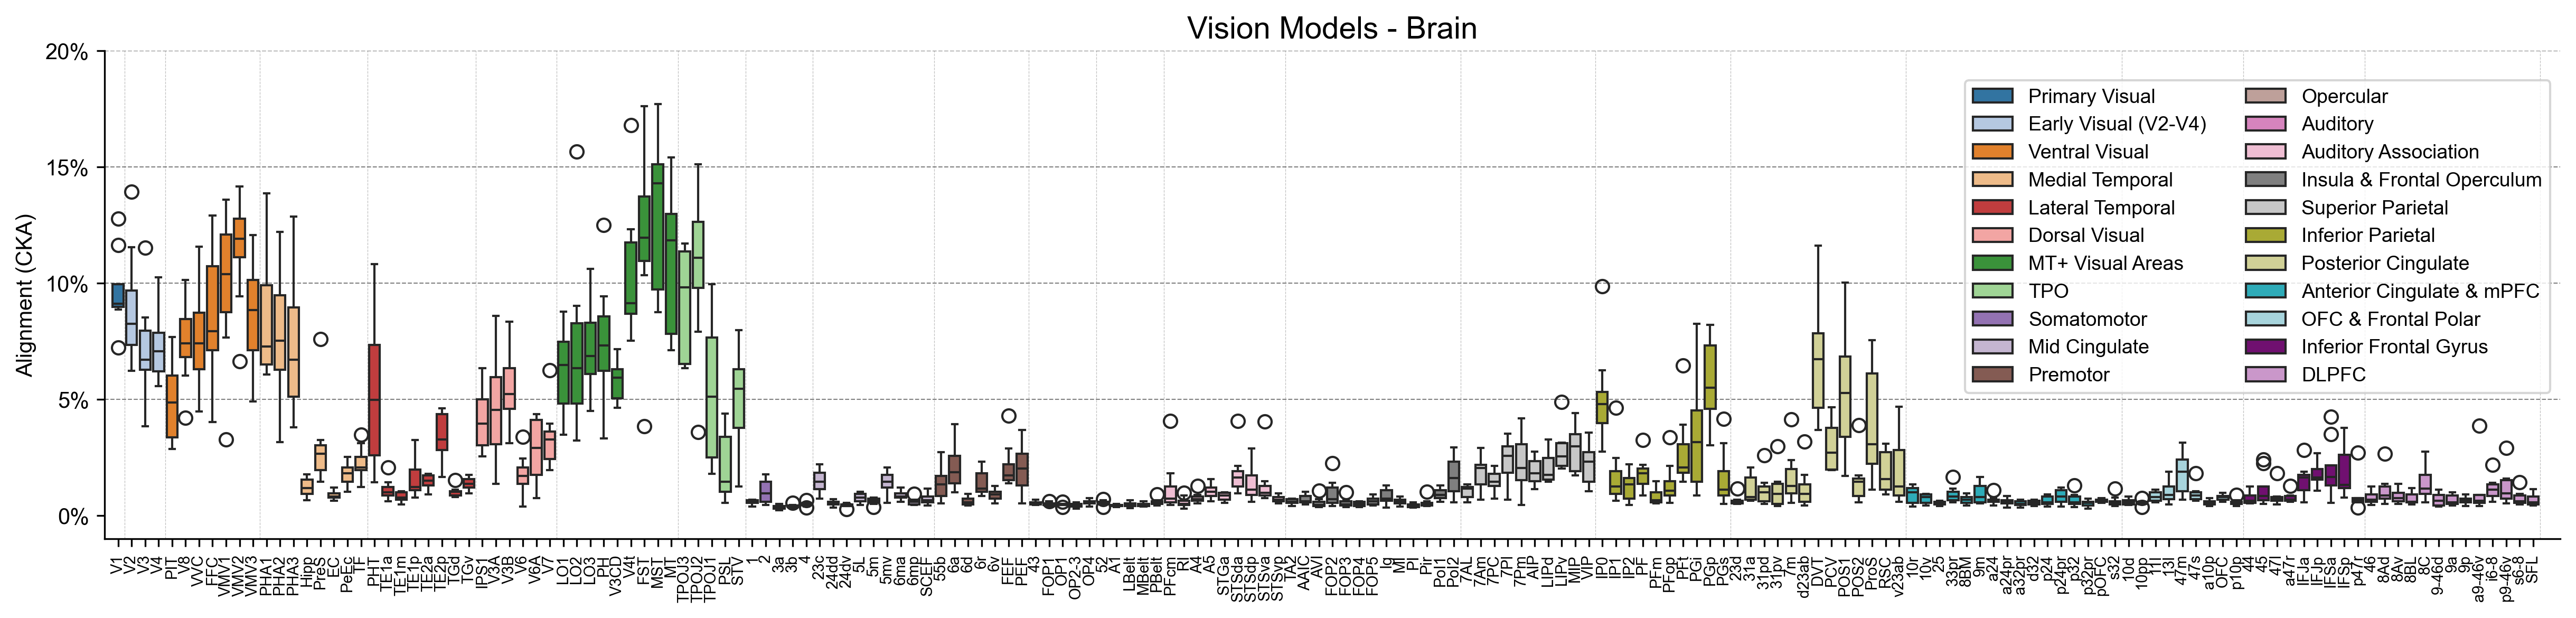

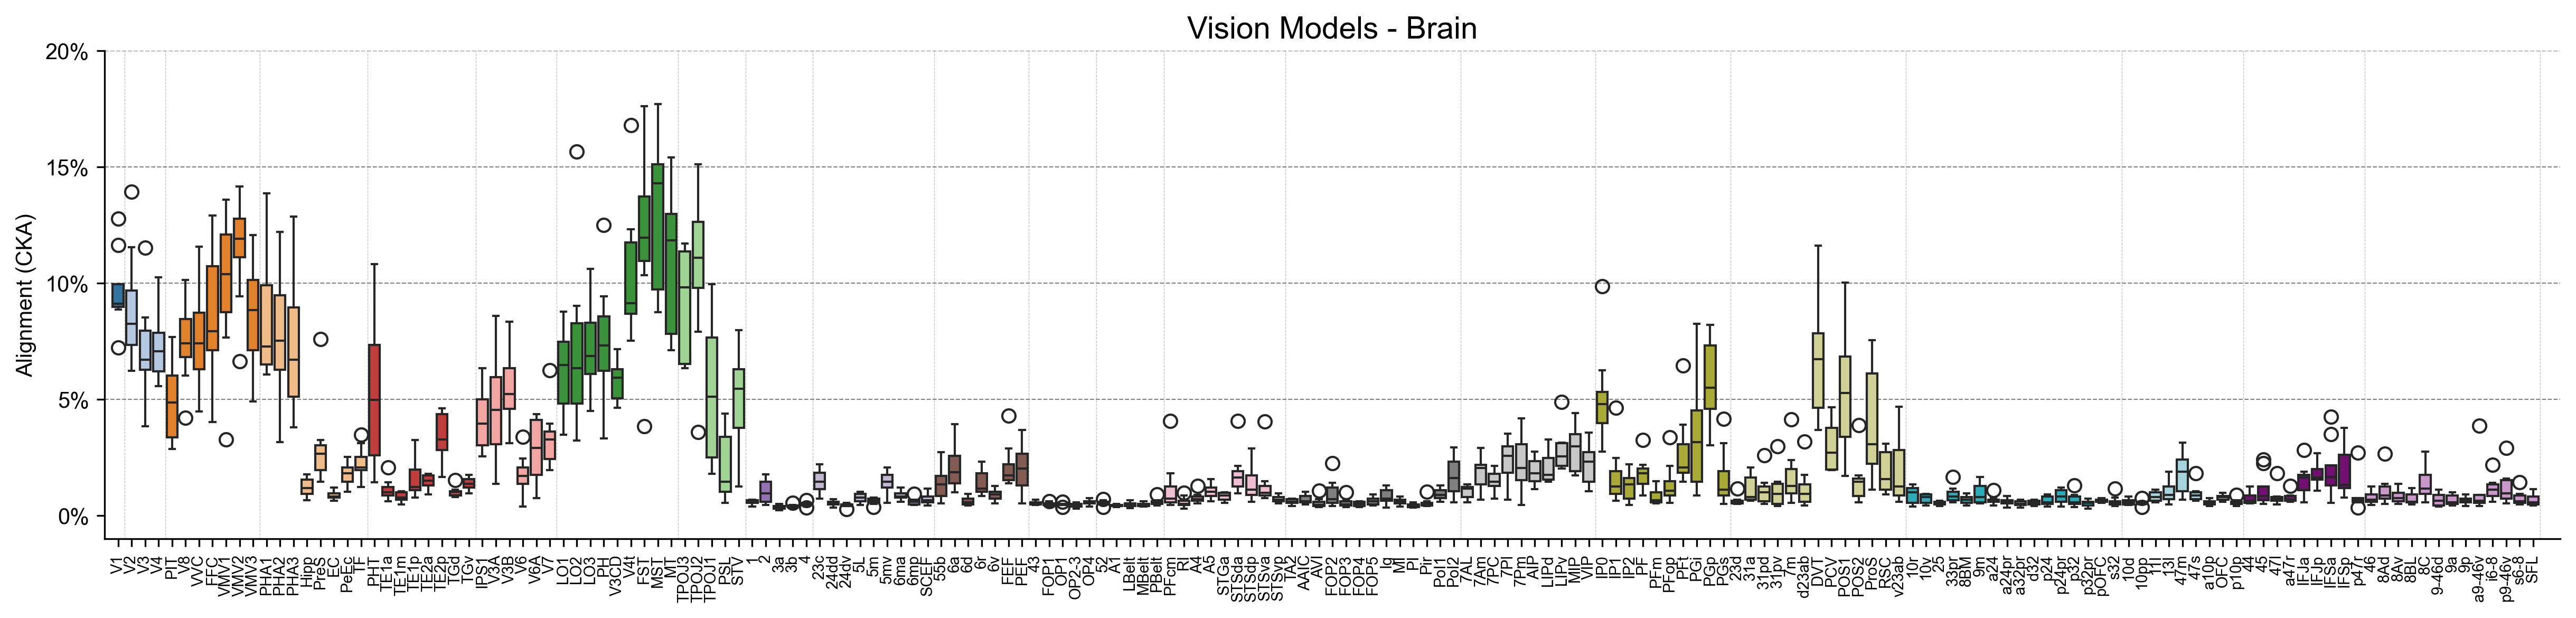

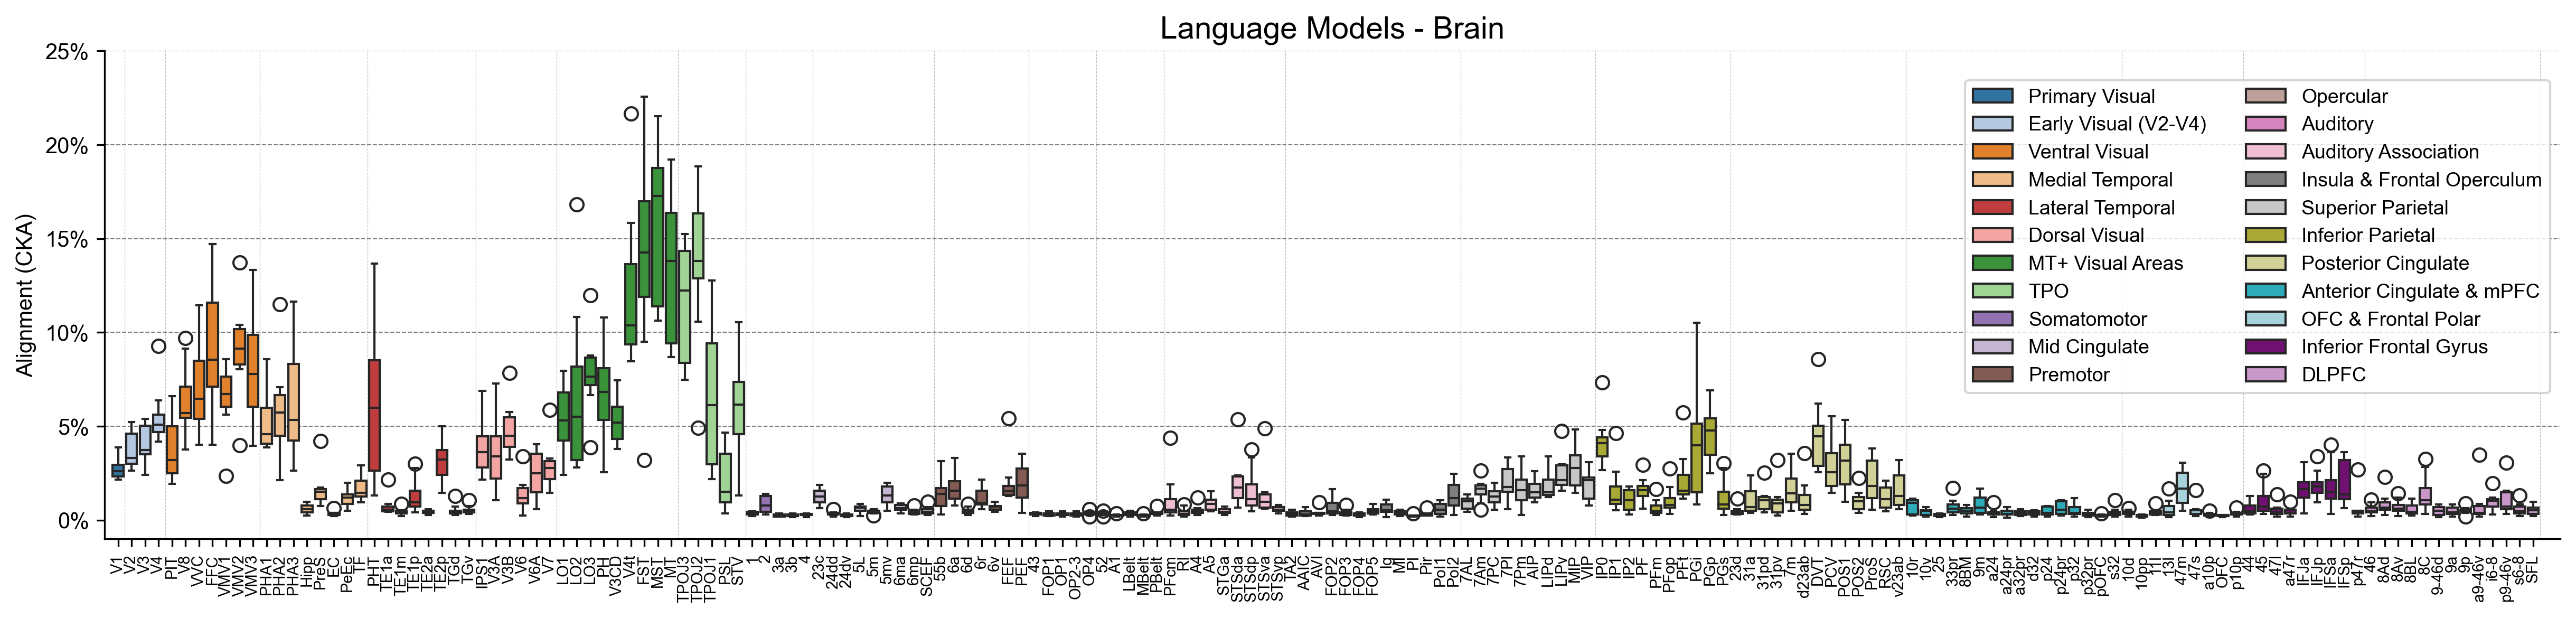

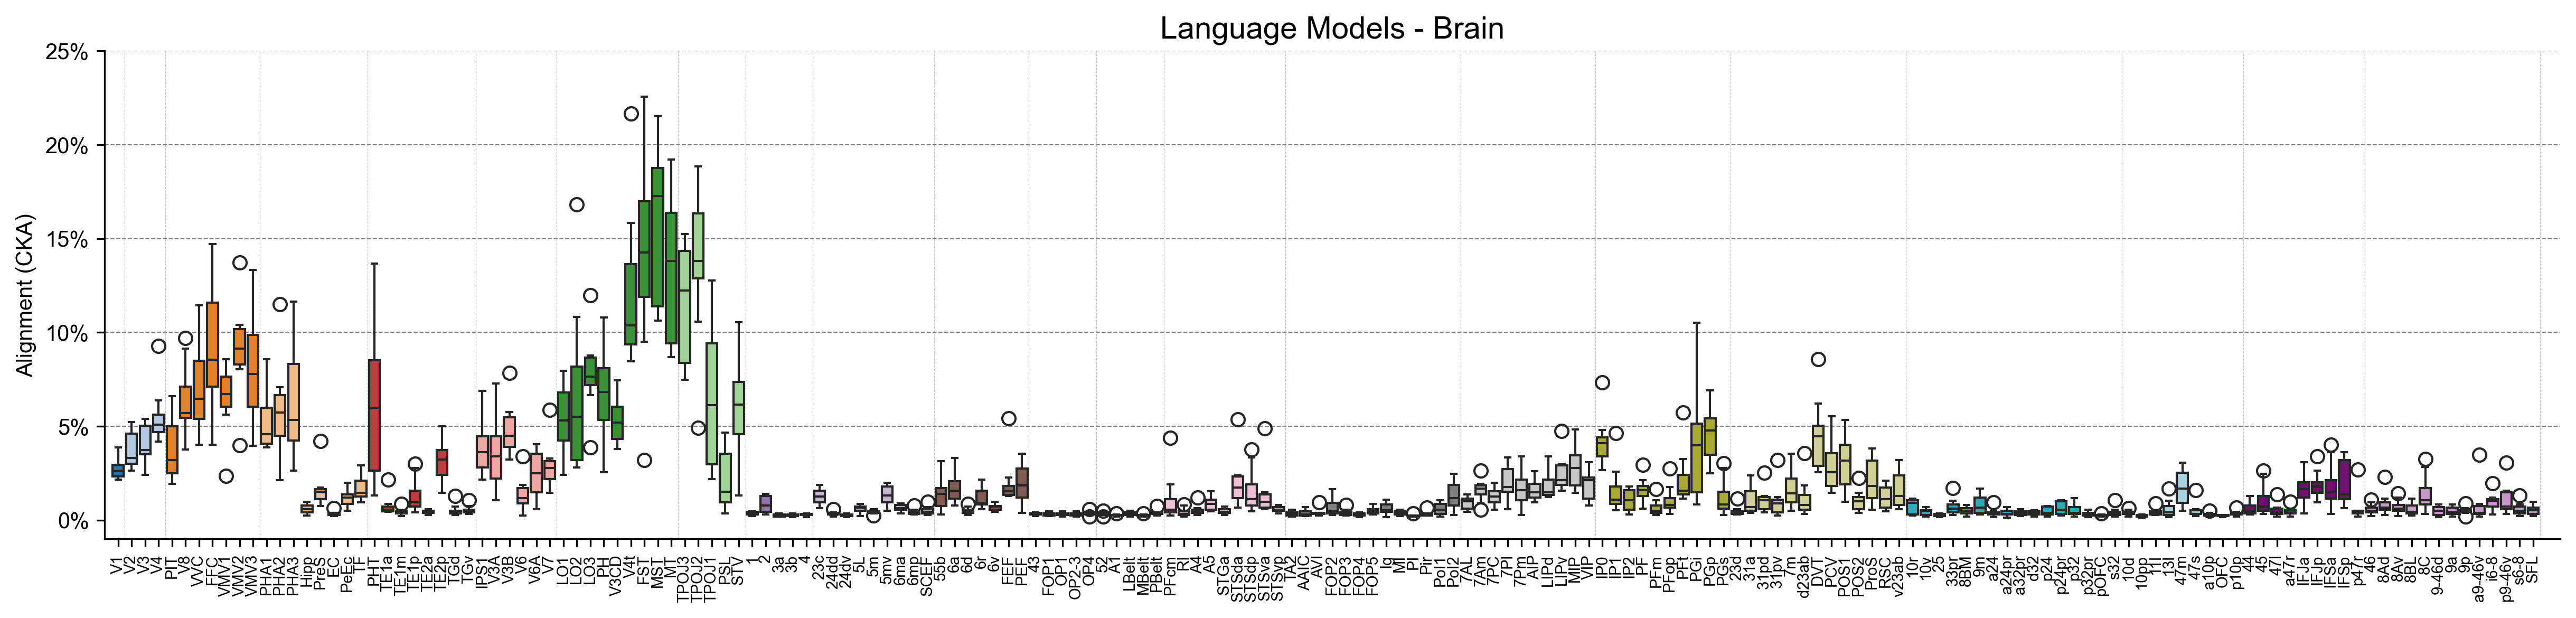

In [87]:
folder = output_folder / Path("model_spatial_boxplots")
folder.mkdir(exist_ok=True)
for modality in ["vision", "language"]:
    for legend in [True, False]:
        df_g = load_model_spatial(filename_model_joined, filename_hcp, modality=modality, join_subject=False)
        vmax = 0.2 if modality == "vision" else 0.25

        df_g.area = df_g.area.replace({"Early Visual (V2-4)": "Early Visual (V2-V4)"})
        df_g.name = df_g.name.replace({"H": "Hipp"})
        order = list(df_g.sort_values(["area_id", "roi_order"]).name.unique())
        hue_order = list(df_g.sort_values("area_id").area.unique())
        palette = list(df_g.sort_values("area_id").area_color.unique())

        fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=300)
        plot_all_rois(
            df_g,
            ax,
            order,
            hue_order,
            palette,
            title=f"{modality.capitalize()} Models - Brain",
            legend=legend,
            fontsize=7,
            #legend_fontsize=11,
            legend_kwargs={"bbox_to_anchor": (1, 0.96)},
            vmax=vmax
        )
        # fig.savefig(folder / f"model_{modality}_boxplots{'_legend' if legend else ''}.pdf", bbox_inches="tight", dpi=300, transparent=True)
        # plt.close()

### Subfigs: Comparisons between alignment methods

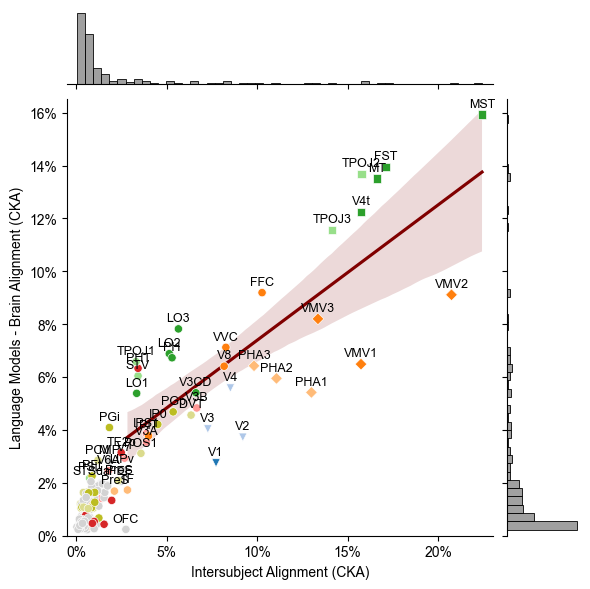

In [333]:
# df_participant = load_cross_participant(filename_joined, filename_hcp, join_subject=True)
# df_participant = df_participant[['roi', "score"]].rename(columns={'score': 'score_participant'})
# df_vision = load_model_spatial(filename_model_joined, filename_hcp, modality="vision", join_subject=True)
# df_vision = df_vision[['roi', 'score']].rename(columns={'score': 'score_vision'})
# df_lang = load_model_spatial(filename_model_joined, filename_hcp, modality="language", join_subject=True)
# df_lang = df_lang.rename(columns={'score': 'score_language'})
# df_mix = df_participant.merge(df_vision, on='roi').merge(df_lang, on='roi')

df_mix["cluster"] = "Other Rois"
vc_cluster = ["V1", "V2", "V3", "V4"]
mt_cluster = ["MST", "MT", "V4t", "FST", "TPOJ2", "TPOJ3"]
ppa_cluster = ["PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"]
df_mix.loc[df_mix.name.isin(vc_cluster), "cluster"] = "Visual Cortex"
df_mix.loc[df_mix.name.isin(ppa_cluster), "cluster"] = "Ventral Hub"
df_mix.loc[df_mix.name.isin(mt_cluster), "cluster"] = "Dorsal Hub"

# light gray area color to the rest of the areas not in selected_areas
df_mix.loc[~df_mix.area_id.isin(selected_areas), "area_color"] = "#D3D3D3"

style_markers = {"Visual Cortex": 'v', "Ventral Hub": 'D', "Dorsal Hub": 's', "Other Rois": 'o'}
#display(df_mix)
axis_labels = {
    'score_vision': 'Vision Models - Brain Alignment (CKA)',
    'score_language': 'Language Models - Brain Alignment (CKA)',
    'score_participant': 'Intersubject Alignment (CKA)'
}

x, y = 'score_participant', 'score_vision'
ylim = (0, 0.165)
xlim = (-0.005, 0.23)
folder = output_folder / Path("alignment_comparison")
folder.mkdir(exist_ok=True)
g = plot_comparison(df_mix, x=x, y=y, threshold=0.02, xlabel=axis_labels[x], xlim=xlim, ylabel=axis_labels[y], ylim=ylim, fontsize=9, scatter_kws={"style": "cluster", "markers": style_markers}, legend=True)

handles, labels = g.ax_joint.get_legend_handles_labels()
handles, labels = handles[-4:], labels[-4:]
# Sort by name
order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub", "Other Rois"]
handles = [handles[labels.index(name)] for name in order]
labels = order
g.ax_joint.legend(handles=handles[-4:], labels=labels[-4:], title="Hub", bbox_to_anchor=(1, 0.3), fontsize=10)
xlims = g.ax_joint.get_xlim()
ylims = g.ax_joint.get_ylim()
sns.regplot(data=df_mix.query(f"{x}>0.028"), x=x, y=y, scatter=False, line_kws={'color': 'maroon', "zorder":-10}, ax=g.ax_joint)
g.ax_joint.set_xlim(xlims)
g.ax_joint.set_ylim(ylims)
# Set xlabel
g.ax_joint.set_xlabel(axis_labels[x])
g.ax_joint.set_ylabel(axis_labels[y])
# g.savefig(folder / "cross_participant_vision_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)

plt.close()
x, y = 'score_participant', 'score_language'
g = plot_comparison(df_mix, x=x, y=y, threshold=0.02, xlabel=axis_labels[x], xlim=xlim, ylabel=axis_labels[y], ylim=ylim, fontsize=9, scatter_kws={"style": "cluster", "markers": style_markers}, legend=False)
sns.regplot(data=df_mix.query(f"{x}>0.028"), x=x, y=y, scatter=False, line_kws={'color': 'maroon', "zorder":-10}, ax=g.ax_joint)
g.ax_joint.set_xlabel(axis_labels[x])
g.ax_joint.set_ylabel(axis_labels[y])
g.savefig(folder / "cross_participant_language_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)
# # #plt.close()
# # x, y = 'score_vision', 'score_language'
# # g = plot_comparison(df_mix, x=x, y=y, xlabel=labels[x], ylabel=labels[y])
# # g.savefig(folder / "vision_language_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)



### Subfigs: Model alignment hemispheres

In [ ]:
folder = output_folder / Path(f"model_hemispheres_comparison")
folder.mkdir(exist_ok=True)
ylim = (0, 0.165)
for modality in ["vision", "language"]:
    df_model = load_model_spatial(filename_model_separated, filename_hcp, modality=modality, join_subject=True)
    df_model_lh = df_model.query("roi <= 180").rename(columns={'score': 'score_lh'}).copy()
    df_model_rh = df_model.query("roi > 180")[["roi", "score"]].rename(columns={'score': 'score_rh'})
    df_model_rh.roi -= 180
    df_model = df_model_lh.merge(df_model_rh, on='roi')

    x, y = 'score_lh', 'score_rh'
    labels = {
        'score_lh': f'LH - {modality.capitalize()} Models - Brain Alignment (CKA)',
        'score_rh': f'RH - {modality.capitalize()} Models - Brain Alignment (CKA)'
    }
    g = plot_comparison(df_model, x=x, y=y, xlabel=labels[x], ylabel=labels[y], ylim=ylim, add_identity=True)
    g.savefig(folder / f"{modality}_hemispheres_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)
    plt.close()

In [11]:
df_vision = load_model_spatial(filename_model_joined, filename_hcp, modality="vision", join_subject=True)

In [ ]:
hue_order = list(df_vision.sort_values("area_id").area.unique())
palette = list(df_vision.sort_values("area_id").area_color.unique())
g = sns.scatterplot(data=df_vision, x='score', y='area', hue='area', palette=palette, hue_order=hue_order, legend=True)

fig, ax2 = plt.subplots()
ax2.axis('off')
# Add padding/margins inside the box of the legend
leg2 = ax2.legend(*g.get_legend_handles_labels(), ncol=1, loc="center", borderaxespad=20)
fig.tight_layout()

folder = output_folder / Path("model_vision_legend")
folder.mkdir(exist_ok=True)
fig.savefig(folder / "model_vision_legend_1.svg", bbox_inches="tight", transparent=True)


In [43]:
df = pd.read_parquet(filename_partitions)
# ['accessory',
#  'all',
#  'animal',
#  'appliance',
#  'electronic',
#  'food',
#  'furniture',
#  'indoor',
#  'kitchen',
#  'not_accessory',
#  'not_animal',
#  'not_appliance',
#  'not_electronic',
#  'not_food',
#  'not_furniture',
#  'not_indoor',
#  'not_kitchen',
#  'not_outdoor',
#  'not_person',
#  'not_sports',
#  'not_vehicle',
#  'outdoor',
#  'person',
#  'random_0',
#  'random_1',
#  'random_2',
#  'random_3',
#  'random_4',
#  'repetition_0',
#  'repetition_1',
#  'repetition_2',
#  'sports',
#  'vehicle']
partition = "kitchen"
df = df.query("metric=='unbiased_cka' and score < 1 and score > -0.05 and repetition_shift==1 and partition==@partition").copy()

df = df.groupby("roi").score.mean().reset_index().sort_values("score", ascending=False)
hcp = pd.read_csv(filename_hcp)
hcp = hcp[["roi", "mne_name", 'area', 'area_id', ]]
df = df.merge(hcp, on="roi")

brain = plot_faverage_parcelation(df, normalize=(0, 0.2))
brain.show()

Areas comparison

In [341]:

df_participant = load_cross_participant(filename_joined, filename_hcp, join_subject=False).rename(columns={"subject_i": "subject"})

df_participant = df_participant[['roi', "score", "subject"]].rename(columns={'score': 'score_participant'})
df_vision = load_model_spatial(filename_model_joined, filename_hcp, modality="vision", join_subject=False)

df_vision = df_vision[['roi', 'score', "subject"]].rename(columns={'score': 'score_vision'})
df_lang = load_model_spatial(filename_model_joined, filename_hcp, modality="language", join_subject=False)
df_lang = df_lang[['roi', 'score', 'subject']].rename(columns={'score': 'score_language'})
df_mix = df_participant.merge(df_vision, on=['roi', 'subject'])#.merge(df_lang, on=['roi', 'subject'])
df_mix = df_mix.merge(df_lang, on=['roi', 'subject'])
hcp = pd.read_csv(filename_hcp)
hcp = hcp[["roi", 'area', 'area_id', "area_color", "name"]]
df_mix = df_mix.merge(hcp, on="roi")
df_mix_rois = df_mix.copy()

df_mix["super_area"] = "None"
df_mix.loc[df_mix.name.isin(["V1"]), "super_area"] = "Visual Cortex"
df_mix.loc[df_mix.name.isin(["V2", "V3", "V4"]), "super_area"] = "Visual Cortex"
df_mix.loc[df_mix.name.isin(["MT", "MST", "FST", "V4T"]), "super_area"] = "Dorsal Hub"
df_mix.loc[df_mix.name.isin(["TPOJ2", "TPOJ3"]), "super_area"] = "Dorsal Hub" #"TPOJ2-3"
df_mix.loc[df_mix.name.isin(["PHA1", "PHA2", "PHA3"]), "super_area"] = "Ventral Hub"#"PHA1-3"
df_mix.loc[df_mix.name.isin(["VMV1", "VMV2", "VMV3"]), "super_area"] = "Ventral Hub"
df_mix = df_mix.groupby(["subject", "super_area"]).aggregate({"score_participant": "mean", "score_vision": "mean", "score_language": "mean"}).reset_index()
# Melting the dataframe
df_mix = pd.melt(df_mix, id_vars=["subject", "super_area"], value_vars=["score_participant", "score_vision", "score_language"], var_name="source", value_name="score")
df_mix.source = df_mix.source.str.replace("score_", "").str.capitalize()




In [342]:
df_mix_pivoted = df_mix.pivot_table(index=["subject", "super_area"], columns=["source"], values="score").reset_index().query("super_area != 'None'")

# Do a paired t-test between the Language and Vision models scores, hue by super_area
from scipy.stats import ttest_rel


super_area = "Visual Cortex"
alternative = 'two-sided'
t, p1 = ttest_rel(df_mix_pivoted.query("super_area==@super_area").Vision, df_mix_pivoted.query("super_area==@super_area").Language, alternative=alternative)
d = (df_mix_pivoted.query("super_area==@super_area").Vision.mean() - df_mix_pivoted.query("super_area==@super_area").Language.mean()) / df_mix_pivoted.query("super_area==@super_area").Vision.std()
print(f"{super_area} (vision {'>' if alternative == 'greater' else '<'} language): p={p1:.3f}, t={t:.3f}, d={d:.3f}")

super_area = "Ventral Hub"
alternative = 'two-sided'
t, p2 = ttest_rel(df_mix_pivoted.query("super_area==@super_area").Vision, df_mix_pivoted.query("super_area==@super_area").Language, alternative=alternative)
d = (df_mix_pivoted.query("super_area==@super_area").Vision.mean() - df_mix_pivoted.query("super_area==@super_area").Language.mean()) / df_mix_pivoted.query("super_area==@super_area").Vision.std()
print(f"{super_area} (vision {'>' if alternative == 'greater' else '<'} language): p={p2:.3f}, t={t:.3f}, d={d:.3f}")

super_area = "Dorsal Hub"
alternative = 'two-sided'
t, p3 = ttest_rel(df_mix_pivoted.query("super_area==@super_area").Vision, df_mix_pivoted.query("super_area==@super_area").Language, alternative=alternative)
d = (df_mix_pivoted.query("super_area==@super_area").Vision.mean() - df_mix_pivoted.query("super_area==@super_area").Language.mean()) / df_mix_pivoted.query("super_area==@super_area").Vision.std()
print(f"{super_area} (vision {'>' if alternative == 'greater' else '<'} language): p={p3:.3f}, t={t:.3f}, d={d:.3f}")


Visual Cortex (vision < language): p=0.000, t=12.837, d=2.365
Ventral Hub (vision < language): p=0.000, t=9.073, d=0.859
Dorsal Hub (vision < language): p=0.000, t=-8.485, d=-0.927


In [345]:

import statsmodels.api as sm
from scipy import stats

for c in ["score_vision", "score_language"]:
    df_aux = df_mix_rois.groupby(["roi"]).aggregate({"score_participant": "mean", "score_vision": "mean", "score_language": "mean"}).reset_index()
    df_aux = df_aux.query(f"score_participant > 0.028")
    # Compute R2 and pearson correlation between the score_participant and score_vision
    X = sm.add_constant(df_aux.score_participant)
    y = df_aux[c]
    model = sm.OLS(y, X)
    results = model.fit()
    r2 = results.rsquared
    r = np.sqrt(r2)
    p = results.pvalues[1]
    # Beta
    beta = results.params[1]
    # Correlation
    r, p = stats.pearsonr(df_aux.score_participant, df_aux[c])

    print(f"R2: {r2:.3f}, R: {r:.3f}, p: {p:.6f}, beta: {beta:.3f}")

R2: 0.846, R: 0.920, p: 0.000000, beta: 0.416
R2: 0.628, R: 0.793, p: 0.000000, beta: 0.512


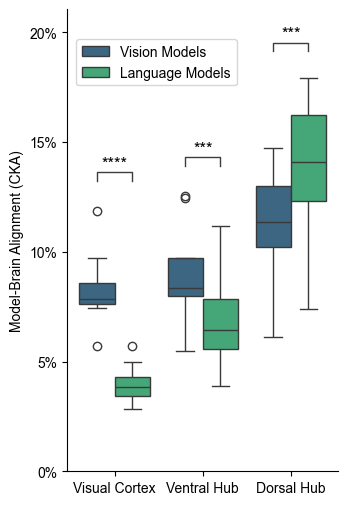

In [381]:
# pip install statannotations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from statannotations.Annotator import Annotator

order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
hue_order = ["Vision Models", "Language Models"]

df_plot = df_mix.copy()
df_plot.source = df_plot.query("source != 'Participant'").source.replace({"Vision": hue_order[0], "Language": hue_order[1]})

fig, ax = plt.subplots(figsize=(3.5, 6))
g = sns.boxplot(
    data=df_plot,
    x='super_area', y='score', hue='source',
    palette="viridis", order=order, hue_order=hue_order,
    ax=ax
)

# Move legend
g.legend_.set_bbox_to_anchor((0.65, 0.95))

# Remove Legend title
g.legend_.set_title("")
ax.set_ylabel("Model-Brain Alignment (CKA)")
ax.set_xlabel("")
ax.set_ylim(0, .2)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
sns.despine(ax=ax)

#  Correct the 3 p-values

from statsmodels.stats.multitest import multipletests


# Bonferroni correction
pvalues_corrected = multipletests(pvalues, method='bonferroni')[1]


# Define which groups to compare
pairs = [
    (("Visual Cortex", hue_order[0]), ("Visual Cortex", hue_order[1])),
    (("Ventral Hub", hue_order[0]), ("Ventral Hub", hue_order[1])),
    (("Dorsal Hub", hue_order[0]), ("Dorsal Hub", hue_order[1])),
]

# Create an Annotator
annotator = Annotator(
    ax,
    pairs,
    data=df_plot,
    x="super_area", y="score", hue="source",
    order=order, hue_order=hue_order,
)

# Configure the appearance of brackets and text
annotator.configure(
    test=None,               # or "t-test_ind", "Mann-Whitney", etc.
    text_format="star",
    verbose=0,
    # -- Style tweaks --
    #line_offset_to_box=0.1,  # gap from box to the bracket start
    #line_offset=0.02,        # gap from bracket to text
    #bracket_width=0.1,       # horizontal bracket width
    line_width=1,
    fontsize="large",
    color=(0.24, 0.24, 0.24)
)

# If you have real p-values, set them here; otherwise just force ***:
annotator.set_pvalues(pvalues_corrected)
annotator.annotate()


folder = output_folder / Path("model_vision_language_comparison")
folder.mkdir(exist_ok=True)
fig.savefig(folder / "model_vision_language_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(folder / "model_vision_language_comparison.pdf", bbox_inches="tight", dpi=300, transparent=True)




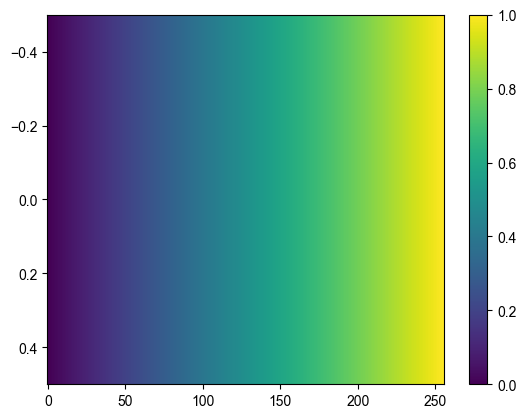

In [379]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = [
    (0, "#2E86C1"),  # Blue at 0.2
    
    #(0.3, "white"),
    (0.6, "orange"),
    (1, "#C0392B")   # Red at 0.8
]

#cmap = LinearSegmentedColormap.from_list("my_cmap", colors)
cmap = "viridis"
# Test plot
import numpy as np
x = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(x, aspect='auto', cmap=cmap)
plt.colorbar()
plt.show()
